# Grid Search
## Set up

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Getting data
loading in preprocessed data saved as "all_projects.csv"

In [3]:
df_all = pd.read_csv("all_projects.csv")

## Creating training and testing datasets
For the training the columns "project" and "project_url" should not have an effect on sustainability. The columns "init" and "end" should not have an effect either. The running time of the project is present in STA-1 (which is calculated from "init" and "end").

The data is divided into X and y:
- X: the factors that we want to use to predict the value of y
- y: the factor we want to predict (sustainable or unstainable)

Furthermore the data is split into "train" and "test":
- "train": is to be used for training the model
- "test": is used to measure its accuracy after training.

In [4]:
df_all = df_all.drop(columns=["project","init","end","project_url"])

X = df_all.drop(columns=["status"])
y = df_all["status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
print("Number of data rows in train:", X_train.shape[0])
print("Number of data rows in test:", X_test.shape[0])

Number of data rows in train: 252
Number of data rows in test: 85


## Grid Search of models
Grid search is used to find the best parameters for a model, by testing how well they score on the dataset. They can be scored on multiple parameters, but in our case we have choosen to find the best parameters based on their ROC-AUC score.

We have choosen to test the same models as the paper before us did.

In [6]:
y_pred = np.zeros_like(y_test)

In [7]:
# Set random seed for reproducibility
random_seed = np.random.seed(42)

In [80]:
classifiers = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_seed),
    'Decision Tree': DecisionTreeClassifier(random_state=random_seed),
    'Random Forest': RandomForestClassifier(random_state=random_seed),
    'Support Vector Machine': SVC(random_state=random_seed, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_seed)
}

param_grids = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10], 'min_samples_leaf': [1, 5]},
    'Support Vector Machine': {'C': [0.1, 1, 10]},
    'Gradient Boosting': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

In [9]:
best_models = {}
for name, classifier in classifiers.items():
    print(f"\n{80*'-'}\n{f'Training {name}':^80}\n{80*'-'}")
    grid_search = GridSearchCV(classifier, param_grid=param_grids[name], scoring='roc_auc', cv=5)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Training ROC-AUC: {grid_search.best_score_:.2f}")


--------------------------------------------------------------------------------
                              Training Naive Bayes                              
--------------------------------------------------------------------------------
Best Hyperparameters: {}
Training ROC-AUC: 0.75

--------------------------------------------------------------------------------
                          Training Logistic Regression                          
--------------------------------------------------------------------------------
Best Hyperparameters: {'C': 0.1}
Training ROC-AUC: 0.79

--------------------------------------------------------------------------------
                             Training Decision Tree                             
--------------------------------------------------------------------------------
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10}
Training ROC-AUC: 0.87

-------------------------------------------------

In [10]:
print("\nTest Set Evaluation:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {accuracy:.2f}")


Test Set Evaluation:
Naive Bayes: Accuracy = 0.55
Logistic Regression: Accuracy = 0.86
Decision Tree: Accuracy = 0.81
Random Forest: Accuracy = 0.89
Support Vector Machine: Accuracy = 0.86
Gradient Boosting: Accuracy = 0.88


GaussianNB does not have feature importances.
LogisticRegression does not have feature importances.


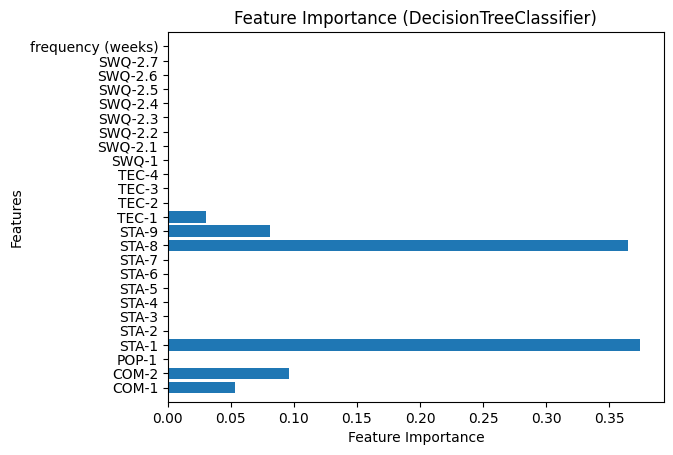

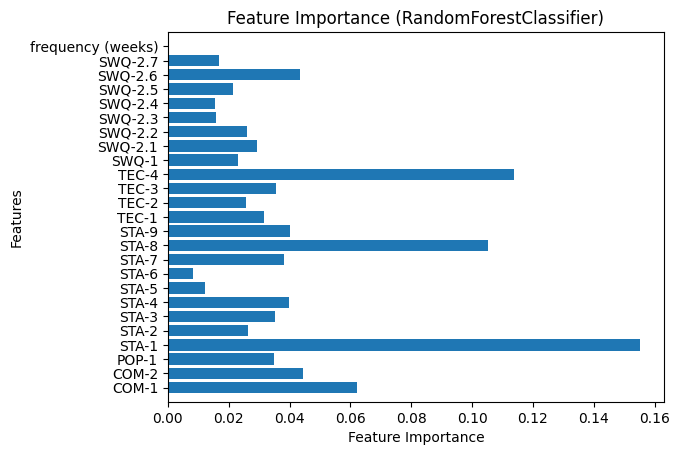

SVC does not have feature importances.


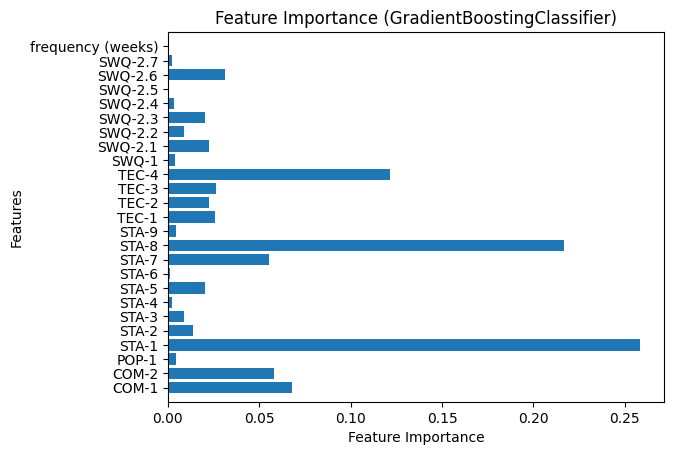

In [11]:
def plot_feature_importances(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        # For models that have feature_importances_
        n_features = len(feature_names)
        plt.barh(np.arange(n_features), model.feature_importances_, align='center')
        plt.yticks(np.arange(n_features), feature_names)
        plt.xlabel("Feature Importance")
        plt.ylabel("Features")
        plt.ylim(-1, n_features)
        plt.title(f"Feature Importance ({model.__class__.__name__})")
        plt.show()
    else:
        print(f"{model.__class__.__name__} does not have feature importances.")

for name, model in best_models.items():
    plot_feature_importances(model, X.columns.tolist())


In [1]:
from sklearn.metrics import ConfusionMatrixDisplay

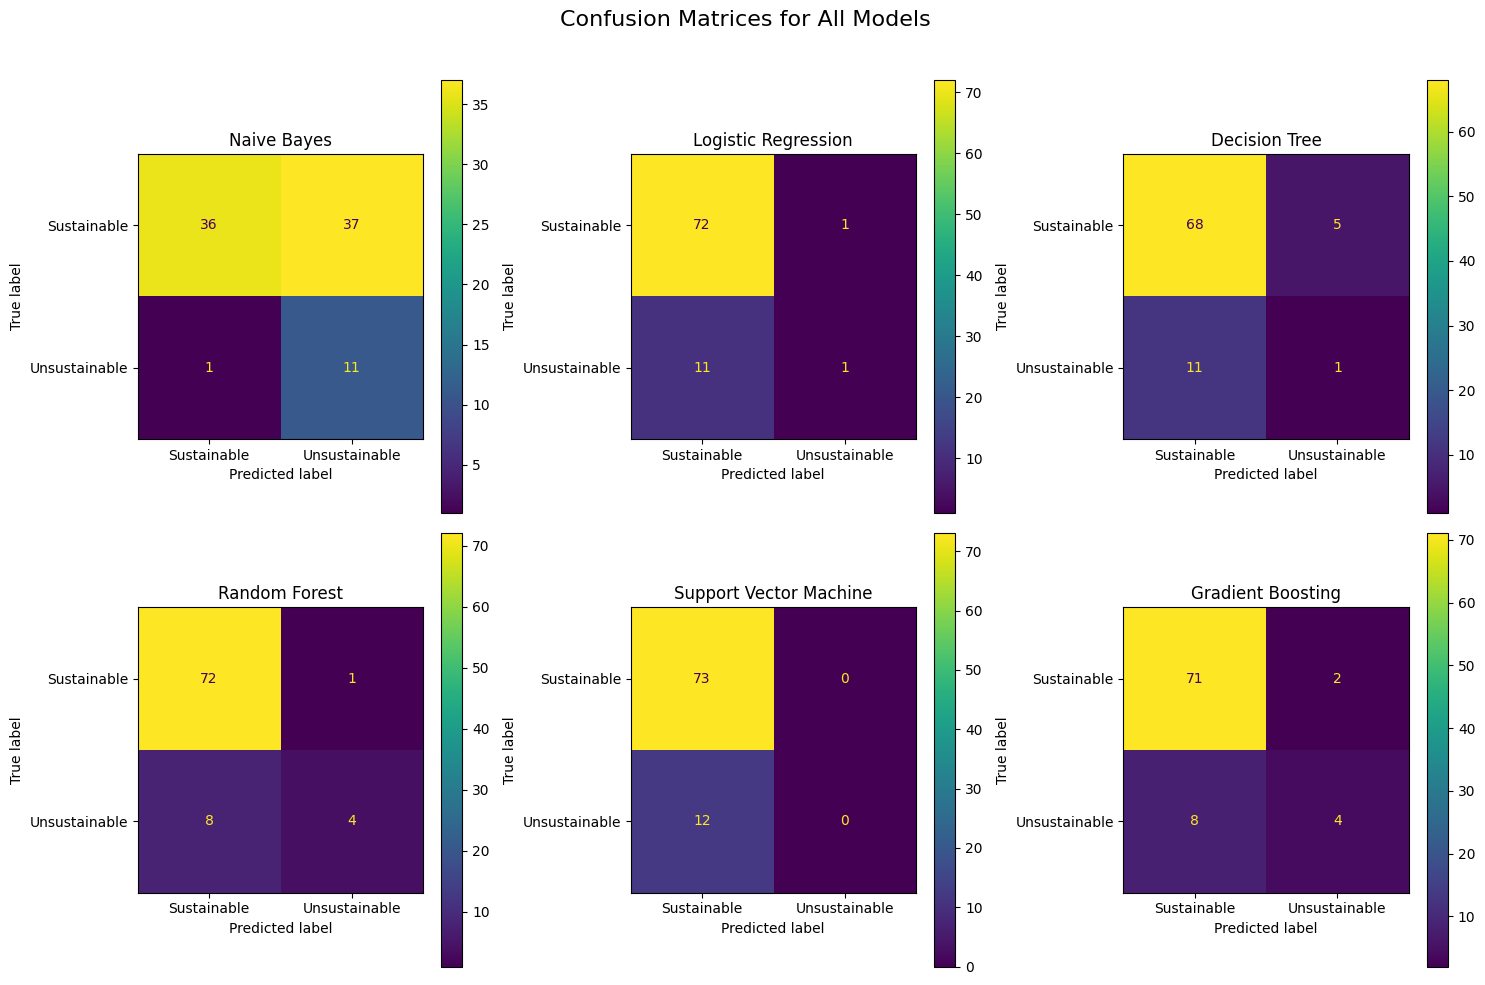

In [19]:
class_labels = ["Sustainable", "Unsustainable"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
fig.suptitle("Confusion Matrices for All Models", fontsize=16)

axes = axes.flatten()

for idx, (name, model) in enumerate(best_models.items()):
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=class_labels, ax=axes[idx]
    )
    axes[idx].set_title(f"{name}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Oversampling 
Helps balance the dataset by duplicating or generating new minority class samples.

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [82]:
sampling_names = ["SMOTE", "Random Oversampling", "ADASYN"]
results = {sampling_name: {} for sampling_name in sampling_names}

def compute_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='sustainable')
    recall = recall_score(y_test, y_pred, pos_label='sustainable')
    f1 = f1_score(y_test, y_pred, pos_label='sustainable')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    return accuracy, precision, recall, f1, roc_auc

def train_models(sampling_name, sampler):
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

    print(f"Original class distribution:\n{y_train.value_counts()}")
    print(f"\n Resampled class distribution:\n{y_resampled.value_counts()}")

    
    best_models_sampled = {}
    for name, classifier in classifiers.items():
        print(f"\n{80*'-'}\n{f'Training {name} ({sampling_name})':^80}\n{80*'-'}")
        grid_search = GridSearchCV(classifier, param_grid=param_grids[name], scoring='roc_auc', cv=5)
        grid_search.fit(X_resampled, y_resampled)

        best_model = grid_search.best_estimator_
        best_models_sampled[name] = best_model

        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Training ROC-AUC: {grid_search.best_score_:.2f}")

    # Metrics
    for name, model in best_models_sampled.items():
        accuracy, precision, recall, f1, roc_auc = compute_metrics(model, X_test, y_test)
        
        # Store the results
        results[sampling_name][name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }

    # Confusion Matrix
    print(f"\nGenerating Confusion Matrices ({sampling_name})...")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Confusion Matrices ({sampling_name})", fontsize=16)

    axes = axes.flatten()
    class_labels = ["Sustainable", "Unsustainable"]

    for idx, (name, model) in enumerate(best_models_sampled.items()):
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=class_labels, ax=axes[idx])
        axes[idx].set_title(f"{name}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## SMOTE (Synthetic Minority Over-sampling Technique)
Generates synthetic samples by interpolating between existing minority class instances.

Original class distribution:
status
sustainable      217
unsustainable     35
Name: count, dtype: int64

 Resampled class distribution:
status
sustainable      217
unsustainable    217
Name: count, dtype: int64

--------------------------------------------------------------------------------
                          Training Naive Bayes (SMOTE)                          
--------------------------------------------------------------------------------
Best Hyperparameters: {}
Training ROC-AUC: 0.85

--------------------------------------------------------------------------------
                      Training Logistic Regression (SMOTE)                      
--------------------------------------------------------------------------------
Best Hyperparameters: {'C': 10}
Training ROC-AUC: 0.88

--------------------------------------------------------------------------------
                         Training Decision Tree (SMOTE)                         
-----------------------------------

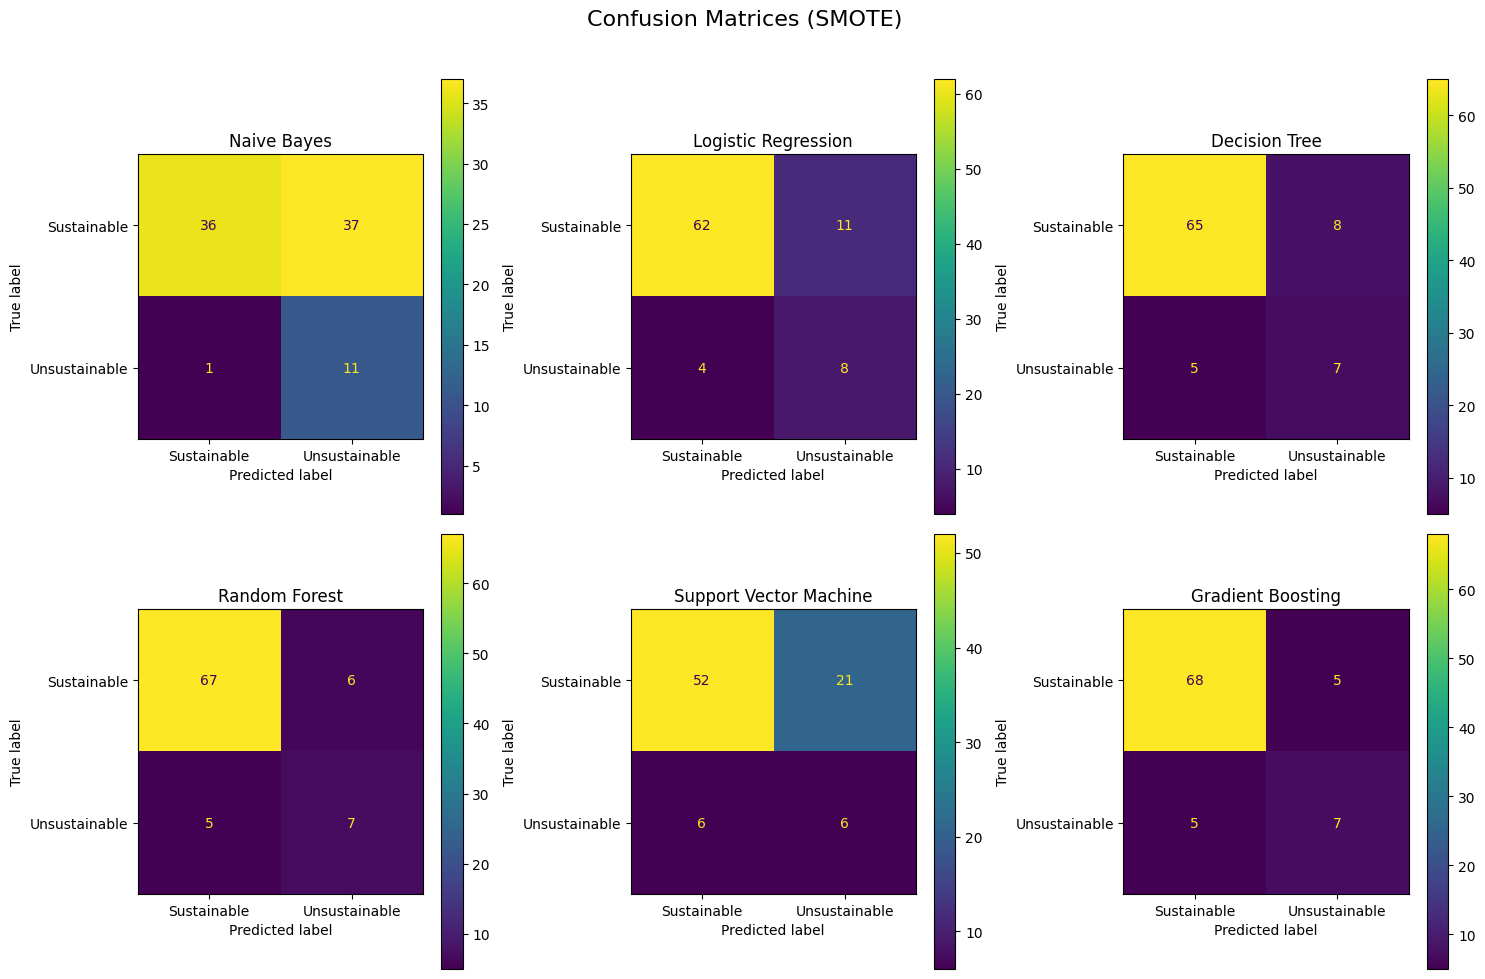

In [83]:
from imblearn.over_sampling import SMOTE

train_models("SMOTE", SMOTE(random_state=random_seed))

## ADASYN (Adaptive Synthetic Sampling)
Similar to SMOTE but generates samples more aggressively in regions where the minority class is sparse.

Original class distribution:
status
sustainable      217
unsustainable     35
Name: count, dtype: int64

 Resampled class distribution:
status
sustainable      217
unsustainable    217
Name: count, dtype: int64

--------------------------------------------------------------------------------
                         Training Naive Bayes (ADASYN)                          
--------------------------------------------------------------------------------
Best Hyperparameters: {}
Training ROC-AUC: 0.84

--------------------------------------------------------------------------------
                     Training Logistic Regression (ADASYN)                      
--------------------------------------------------------------------------------
Best Hyperparameters: {'C': 10}
Training ROC-AUC: 0.88

--------------------------------------------------------------------------------
                        Training Decision Tree (ADASYN)                         
-----------------------------------

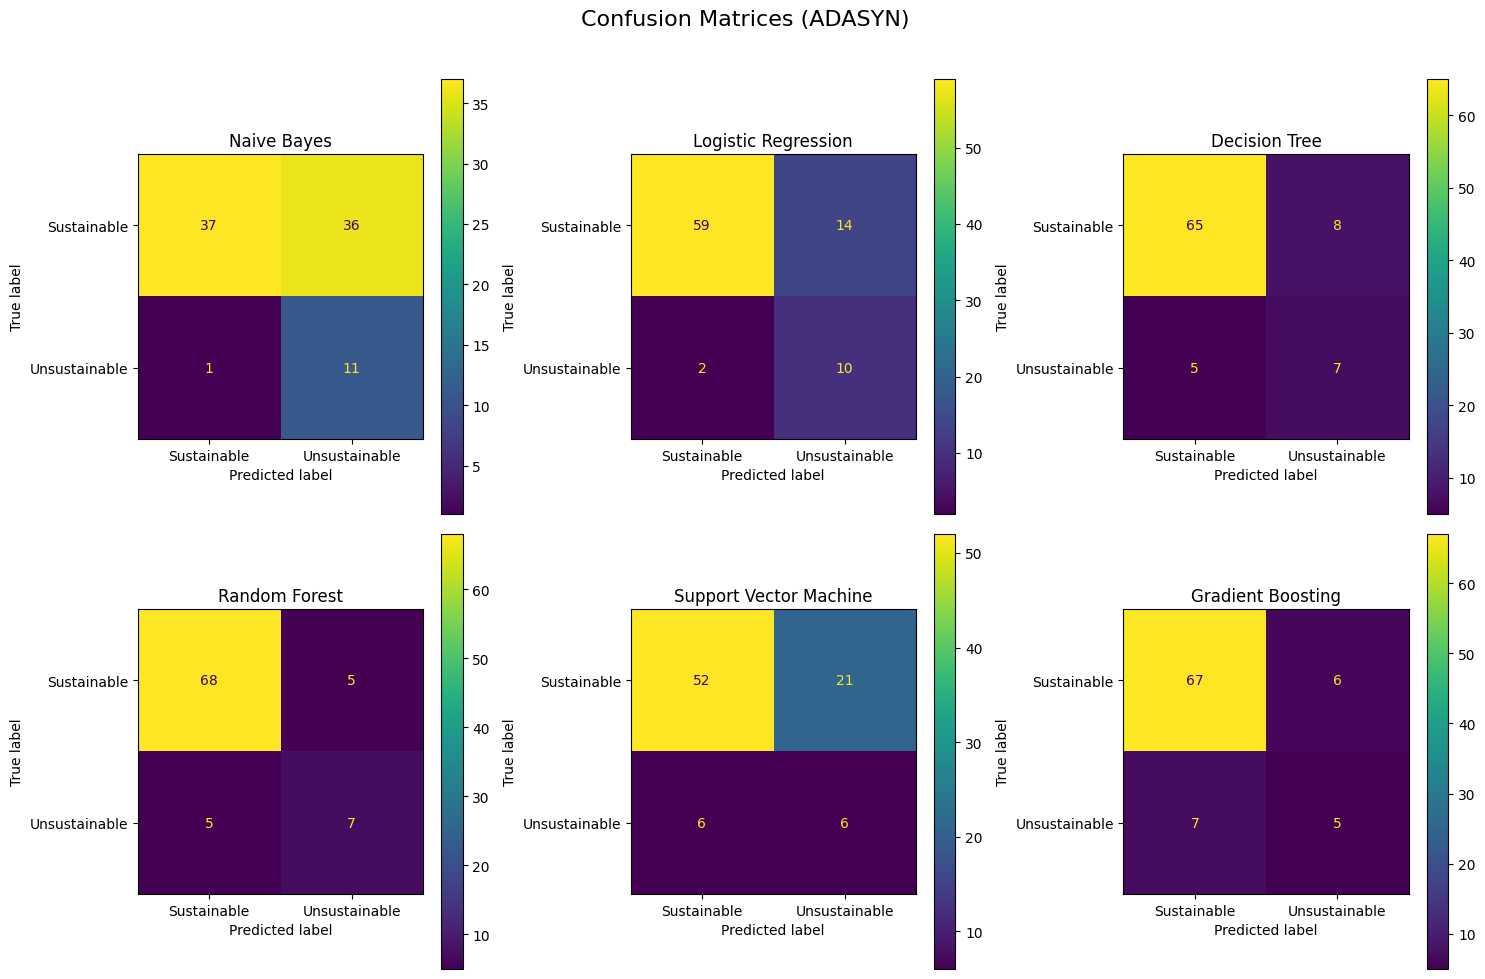

In [85]:
from imblearn.over_sampling import ADASYN

train_models("ADASYN", ADASYN(random_state=random_seed))

## Random Oversampling
Simply duplicates existing minority class samples.

Original class distribution:
status
sustainable      217
unsustainable     35
Name: count, dtype: int64

 Resampled class distribution:
status
sustainable      217
unsustainable    217
Name: count, dtype: int64

--------------------------------------------------------------------------------
                   Training Naive Bayes (Random Oversampling)                   
--------------------------------------------------------------------------------
Best Hyperparameters: {}
Training ROC-AUC: 0.83

--------------------------------------------------------------------------------
               Training Logistic Regression (Random Oversampling)               
--------------------------------------------------------------------------------
Best Hyperparameters: {'C': 0.1}
Training ROC-AUC: 0.86

--------------------------------------------------------------------------------
                  Training Decision Tree (Random Oversampling)                  
----------------------------------

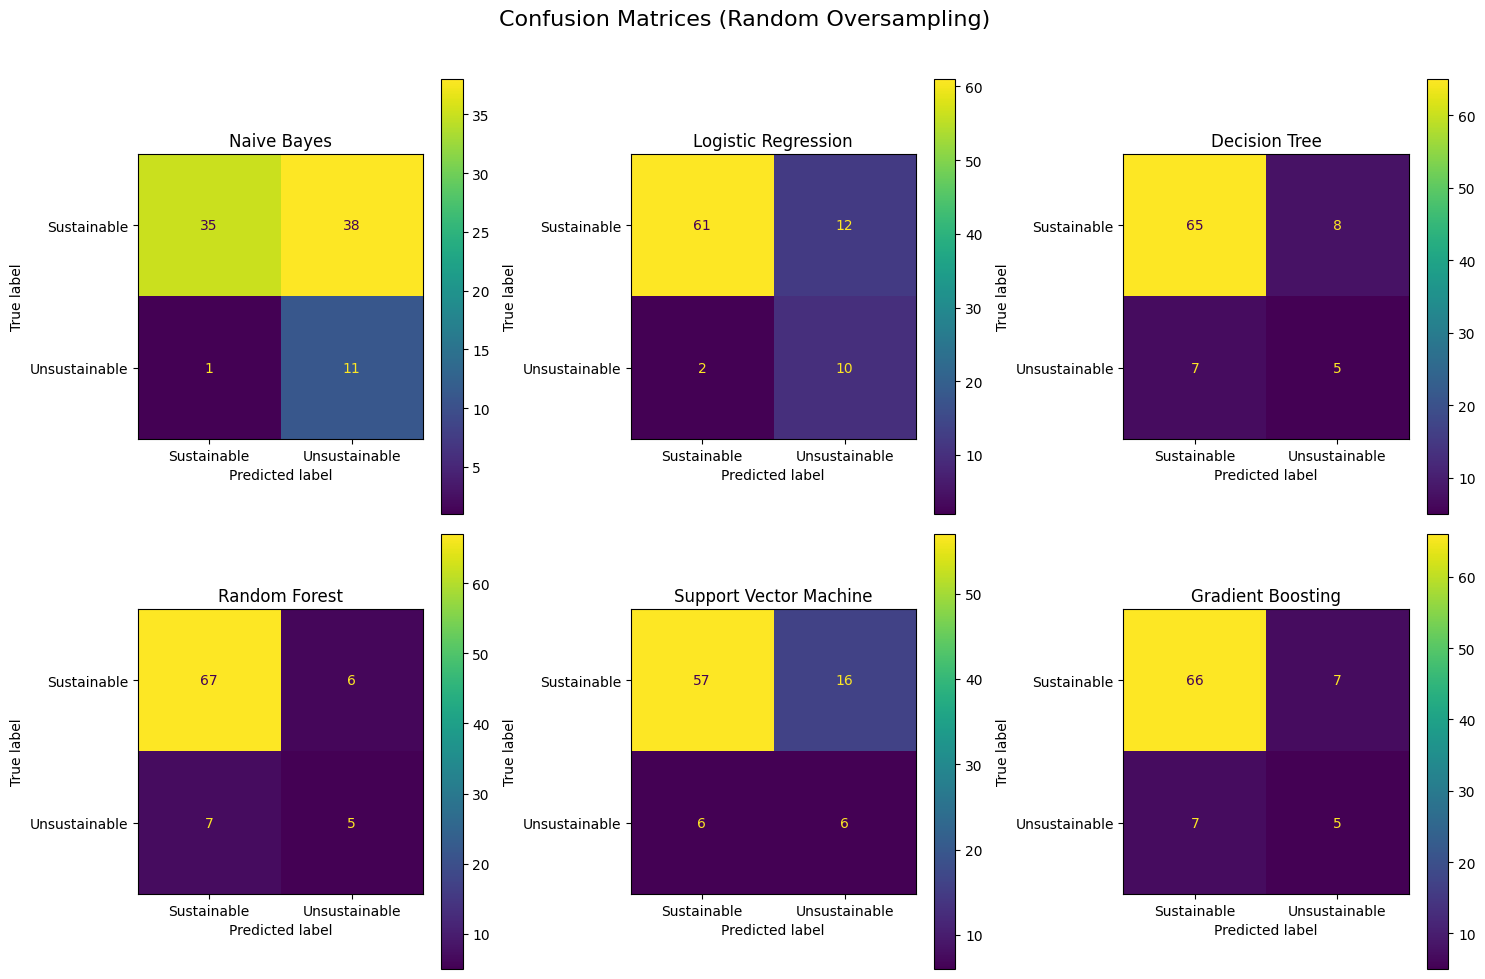

In [86]:
from imblearn.over_sampling import RandomOverSampler

train_models("Random Oversampling", RandomOverSampler(random_state=random_seed))

In [87]:
print("\nComparison of Results (Metrics for Different Sampling Techniques):")
for sampling_name, models in results.items():
    print(f"\n{sampling_name}:")
    for model_name, metrics in models.items():
        print(f"\n{model_name}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")


Comparison of Results (Metrics for Different Sampling Techniques):

SMOTE:

Naive Bayes:
  Accuracy: 0.55
  Precision: 0.97
  Recall: 0.49
  F1-Score: 0.65
  ROC-AUC: 0.76

Logistic Regression:
  Accuracy: 0.82
  Precision: 0.94
  Recall: 0.85
  F1-Score: 0.89
  ROC-AUC: 0.88

Decision Tree:
  Accuracy: 0.85
  Precision: 0.93
  Recall: 0.89
  F1-Score: 0.91
  ROC-AUC: 0.72

Random Forest:
  Accuracy: 0.87
  Precision: 0.93
  Recall: 0.92
  F1-Score: 0.92
  ROC-AUC: 0.87

Support Vector Machine:
  Accuracy: 0.68
  Precision: 0.90
  Recall: 0.71
  F1-Score: 0.79
  ROC-AUC: 0.63

Gradient Boosting:
  Accuracy: 0.88
  Precision: 0.93
  Recall: 0.93
  F1-Score: 0.93
  ROC-AUC: 0.84

Random Oversampling:

Naive Bayes:
  Accuracy: 0.54
  Precision: 0.97
  Recall: 0.48
  F1-Score: 0.64
  ROC-AUC: 0.76

Logistic Regression:
  Accuracy: 0.84
  Precision: 0.97
  Recall: 0.84
  F1-Score: 0.90
  ROC-AUC: 0.88

Decision Tree:
  Accuracy: 0.82
  Precision: 0.90
  Recall: 0.89
  F1-Score: 0.90
  ROC-

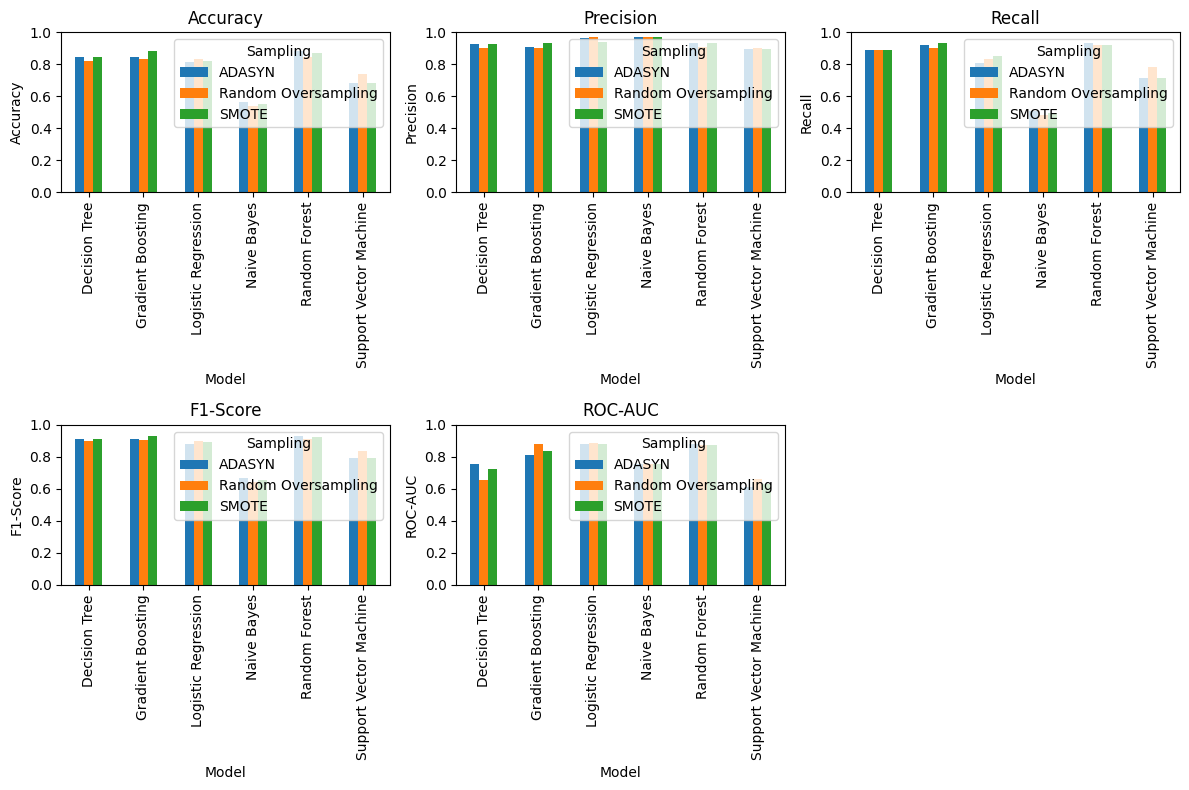

In [88]:
comparison_data = []

for sampling_name, models in results.items():
    for model_name, metrics in models.items():
        for metric, value in metrics.items():
            comparison_data.append({
                'Sampling': sampling_name,
                'Model': model_name,
                'Metric': metric,
                'Value': value
            })


comparison_df = pd.DataFrame(comparison_data)

plt.figure(figsize=(12, 8))
for metric in comparison_df['Metric'].unique():
    plt.subplot(2, 3, list(comparison_df['Metric'].unique()).index(metric) + 1)
    metric_df = comparison_df[comparison_df['Metric'] == metric]
    pivot_df = metric_df.pivot(index='Model', columns='Sampling', values='Value')
    pivot_df.plot(kind='bar', ax=plt.gca(), title=metric, figsize=(12, 8), ylim=(0, 1))
    plt.ylabel(metric)

plt.tight_layout()
plt.show()



Average Performance Metrics for Each Sampling Method:

SMOTE:
  Accuracy: 0.78
  Precision: 0.93
  Recall: 0.80
  F1-Score: 0.85
  ROC-AUC: 0.78

Random Oversampling:
  Accuracy: 0.77
  Precision: 0.93
  Recall: 0.80
  F1-Score: 0.85
  ROC-AUC: 0.78

ADASYN:
  Accuracy: 0.77
  Precision: 0.93
  Recall: 0.79
  F1-Score: 0.85
  ROC-AUC: 0.78


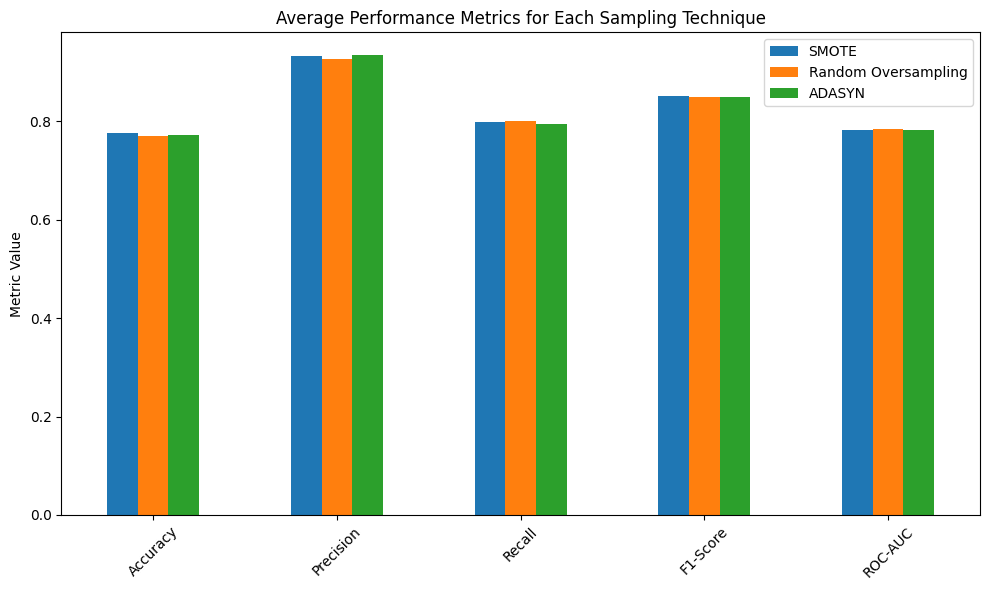

In [89]:
sampling_names = ["SMOTE", "Random Oversampling", "ADASYN"]
average_results = {sampling_name: {} for sampling_name in sampling_names}

for sampling_name, models in results.items():
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
        average_results[sampling_name][metric] = sum(
            metrics[metric] for model_name, metrics in models.items()
        ) / len(models)

print("\nAverage Performance Metrics for Each Sampling Method:")
for sampling_name, metrics in average_results.items():
    print(f"\n{sampling_name}:")
    for metric, avg_value in metrics.items():
        print(f"  {metric}: {avg_value:.2f}")

average_comparison_df = pd.DataFrame(average_results)

average_comparison_df.plot(kind='bar', figsize=(10, 6), title="Average Performance Metrics for Each Sampling Technique")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()